![Banner](img/banner.png)

# **Taller:** Word2Vec

***Matemáticas para Machine Learning***.

**Semana 7 - Práctica Calificada -** Matrices, vectores y espacios vectoriales

**Profesor:** *Fernando Enrique Lozano Martinez* - **Autores Notebook:** *Nicolas Orlando López Cuéllar* y *César Daniel Garrido*


# Introducción

## Descripción

Uno de las áreas de estudio más recientes y relevantes en la inteligencia artificial es el llamado campo del **Procesamiento de Lenguaje Natural** o NLP por sus siglas en inglés. Para esto, uno de los pasos mas importantes consiste en poder representar las palabras de manera númerica o vectorial. En general, sabemos que la representación númerica de un objeto nos permite su análisis mediante la cuantificación de cierta propiedad. Por ejemplo, podemos representar númericamente la palabra "Juan" o la palabra "Maria" a partir de alguna propiedad númerica relevante como su peso o altura.

En el Procesamiento de lenguaje natural la carácteristica que queremos cuantificar es la **Semántica** de las palabras. Queremos representar las palabras de tal manera que se capture su significado en un modo similar al de los seres humanos. Esto no implica conocer su significado exacto, sino está mas enfocado a entender su significado contextual.

**Objetivos de Aprendizaje:**

*   Evaluar algunos de los conceptos vistos durante la semana 1 dentro de un contexto práctico.
*   Implementar funciones que permiten calcular distintos tipos de distancias entre vectores.
*   Introducir conceptos básicos y generalidades del Procesamiento de Lenguaje Natural (NLP) para la representación de palabras como vectores.
*   Analizar las relaciones entre palabras representadas como vectores.



## Metodologia

Para desarrollar el taller usted deberá editar las celdas de código dispuestas para esto. Estas estarán marcadas con el siguiente comentario:

```python
# =====================================================
# COMPLETAR ===========================================
# 

# =====================================================
```

Edite o complete el códgio dentro de estas lineas de comentarios. Dentro de estos comentarios encontrará ayudas del trabajo a realizar, así como algunas de las variables que debe utilizar o calcular. Adiionalmente, Cada punto tendrá una sección de pruebas, esta sección será calificada y se encuentra oculta de los estudiantes.

En este taller también existén preguntas abiertas que no serán calificadas automáticamente al final del laboratorio. Realice las instrucciones que se le dan lo mejor que pueda. Cuando la pregunta o instrucción sea abierta escriba su respuesta completa en la celda que se indica.

# Teoría

## One-Hot Encoder

Un método estándar, y una de las aproximaciones mas sencillas para cuantificar objetos cualitativos consiste en utilizar **codificación one-hot** (One Hot encoding en ingles) Como se muestra en el siguiente ejemplo:

---

Suponga que todo el **vocabulario** al que tenemos acceso para nuestro proceso 
de representación númerica consiste en 4 palabras:

<center> Amarillo , Azul , Rojo , Naranja </center>

Entonces podemos representarlas vectorialmente de la siguiente manera:

$$\begin{split} 
\textrm{Amarillo} \quad \longrightarrow \quad & [ 1, 0 ,0,0] \\
\textrm{Azul} \quad \longrightarrow \quad & [ 0, 1 ,0,0] \\
\textrm{Rojo} \quad \longrightarrow \quad & [ 0, 0 , 1,0] \\
\textrm{Naranja} \quad \longrightarrow \quad & [ 0, 0 ,0, 1] 
\end{split}$$

---

Esta representación tiene varios inconvenientes. El tamaño de los vectores depende del tamaño del vocabulario, el cual puede crecer indefinidamente. Además, utilizar el modelo generado con esta codificación sobre otro vocabulario, quitar o adicionar palabras al vocabulario se convierte en un trabajo poco práctico. Finalmente, esta codificación no captura el significado contextual de las palabras el cual es el objetivo original.

## Word2Vec

Word2Vec es un conjunto de tecnicas creadas, patentadas y publicadas en el 2013 por investigadores de Google. Estas están expuestas en [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781) y en [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546). 

Word2Vec tiene 2 arquitecturas de uso diferentes: EL modelo CBOW, por sus siglas en ingles (Continuous Bag of Words Model) o el modelo Skip-Gram. Ambos modelos utilizan el entrenamiento de redes neuranles para generar las asociaciones de texto. En el modelo Skip-Gram el entraniento se realiza generando una predicción para las palabras en una ventana a partir de una palabra central. El modelo CBOW realiza el entrenamiento prediciendo una palabra central a partir de las palabras en una ventana alrededor de esta.

El modelo Skip-Gram funciona bien para un conjunto de datos pequeño, representando apropiadamente incluso palabras extrañas. El modelo CBOW es mucho más eficiente de entrenar que el Skip-Gram, particularmente para conjuntos de datos grandes. Tiene mejor precisión sobre palabras frecuentes.

# Modelos de *Word2Vec*

A continuación se presenta una pequeña muestra de como utilizar esta libreria para generar modelos de procesamiento de lenguaje natural a partir de fragmentos de 100 años de Soledad. Primero empezamos importando las librerias necesarias para el laboratorio.

In [1]:
# Librerias Básicas
import numpy as np                # Matemáticas
import itertools                  # Manipulación iterables
import pandas as pd
import matplotlib.pyplot as plt   # Visualización

# Word2Vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# Visualización
from IPython.display import display, HTML
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# UTILIDADES =================================
# Correr una única vez por sesión ============
from maiautils import MaiaUtils
ipython = get_ipython()
mutils = MaiaUtils(ipython) 
# ============================================

In [3]:
# Cambiar configuración de informe de errores
mutils.toggle_traceback()

## Función Crear Modelos

La siguiente función genera ambos modelos CBOW y Skip-Gram a partir de un texto de entrada.

In [4]:
def crear_modelo_texto(path:str, size=100, window=5): 
    """
    Crea modelos a partir de un archivo de texto 
    ___________________________________
    Entrada:
    path:   [str] dirección de archivo
    size:   [int] Tamaño de vectores
    window: [int] Tamaño de ventana
    ___________________________________
    Salida:
    cbow:  [gensim.Word2Vec] Continuous Bag of Words Model
    sgram: [gensim.Word2Vec] Skip Gram Model  
    """

    # Lee archivo ‘.txt’ 
    sample = open(path, "r")
    s = sample.read()

    # Reemplaza fin de linea con espacio.
    f = s.replace("\n", " ")

    data = []

    # Itera sobre cada oración
    for i in sent_tokenize(f):
        temp = []

        # Itera sobre cada palabra
        for j in word_tokenize(i):
            temp.append(j.lower())

        data.append(temp)

    # Modelo CBOW 
    cbow = gensim.models.Word2Vec(data, min_count = 1, vector_size = size, window = window) 

    # Modelo Skip Gram
    sgram = gensim.models.Word2Vec(data, min_count = 1, vector_size = size, window = window, sg = 1)

    return cbow, sgram

## Modelos - Gabriel García Marquez

A continuación se leen dos fragmentosdel libro **100 años de soledad** de Gabriel García Marquez , y a partir de cada uno se generan distintos modelos.

In [5]:
# Tamaño de la ventana de palabras
window = 5
# Dimensión de los vectores de representación
size = 10

In [6]:
# Crear Modelos
cbow1, gram1 = crear_modelo_texto('100_años_soledad_corto.txt', size=size, window=window)
cbow2, gram2 = crear_modelo_texto('100_años_soledad_full.txt', size=size, window=window)

# Modelos 
modelos = {
    'CBOW 1': cbow1,
    'Skip-Gram 1': gram1,
    'CBOW 2': cbow2,
    'Skip-Gram 2': gram2,
}

## Vocabulario - Vectores

Cada modelo tiene su correspondiente vocabulario, que incluye todas las palabras y simbolos que se encuentren en el texto de entrenamiento:

In [7]:
# Obtener vocabulario
vocab = modelos['CBOW 1'].wv.index_to_key 
# Mostrar primeros 10 elementos
print(vocab[:10])

['de', ',', 'la', '.', 'y', 'que', 'el', 'en', 'a', 'los']


Podemos tomar alguna palabra que se encuentre en ambos textos y observar su representación vectorial bajo los distintos modelos. En la siguiente tabla vemos como cada uno de los 4 modelos representa la palabra $p$ con un vector de 10 coordenadas. Observe que cuando se usa el texto corto, las representaciones son muy similares, sin embargo, cuando el texto que se usa de entrenamiento aumenta, estas representaciones se vuelven más y más distintas.

In [8]:
# Palabras
p = 'aldea'

In [9]:
# Genera vector para cada modelo
p_vec = {}
for name, model in modelos.items():
    p_vec[name] = model.wv[p]

# Muestra
print("Representación de palabra Aldea:")
mutils.mostrar_tabla(p_vec)

Representación de palabra Aldea:


,0,1,2,3,4,5,6,7,8,9
CBOW 1,0.008446,-0.112672,0.453235,-0.153687,0.192162,0.320091,0.483150,0.512073,-0.720139,-0.120212
Skip-Gram 1,0.039262,-0.037001,0.489713,-0.137031,0.280926,0.376610,0.856717,1.002464,-0.976564,-0.122268
CBOW 2,0.047794,-0.406718,0.106915,-0.157092,-0.035810,-0.067248,0.967877,0.588041,-0.910058,-0.200354
Skip-Gram 2,0.099922,0.283160,-0.321249,-0.143898,0.196543,-0.022601,1.414843,0.543181,-1.320193,0.112501


# Similitud de coseno

Una vez las palabras son representadas con vectores podemos hablar de una distancia entre ellas. Word2Vec incorpora una función de similaridad que permite medir que tan "cercanas" son dos palabras, esta es la similaridad de coseno, la cual es 0 cuando los vectores son perpendiculares, y se acerca a 1 a medida que los vectores son mas cercanos en angulo y en magnitud. De manera analoga, se acerca a -1 cuando los vectores son similares en magnitud, pero su angulo es opuesto el uno del otro.


$$ S_C(\mathbf{v}, \mathbf{u} ) = \frac{\mathbf{v} \cdot \mathbf{u}}{\| \mathbf{v} \| \| \mathbf{u} \|} $$

En donde $\| \mathbf{v} \|$ es la norma euclidiana del vector $\mathbf{v} \in \mathbb{R}^n$ dada por:

$$ \| \mathbf{v} \| = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}$$

Y el numerador es el producto punto de $\mathbf{v}$ y $\mathbf{u}$:

$$ \mathbf{v} \cdot \mathbf{u} = v_1 u_1 + \> \ldots \> + v_n u_n $$

Entonces si tomamos 2 palabras, es posible obtener su similaridad de coseno:

In [10]:
# Palabras
p1 = 'aldea'
p2 = 'frente'

In [11]:
# Similaridad
print(f'CBOW 1      : {cbow1.wv.similarity(p1, p2)}')
print(f'Skip-Gram 1 : {gram1.wv.similarity(p1, p2)}')
print(f'CBOW 2      : {cbow2.wv.similarity(p1, p2)}')
print(f'Skip-Gram 2 : {gram2.wv.similarity(p1, p2)}')

CBOW 1      : 0.9730207920074463
Skip-Gram 1 : 0.9817833304405212
CBOW 2      : 0.9906709790229797
Skip-Gram 2 : 0.9609376192092896


# Problemas

## Similitud coseno

Escriba una función que reciba dos vectores $\mathbf{v}_1, \mathbf{v}_2 \in \mathbb{R}^n$  y encuentre su similaridad de coseno. **IMPORTANTE:**Recuerde que la función interna de Word2Vec que calcula la similaridad de coseno entre dos palabras tiene un extra procesamiento que no es tenido en cuenta en nuestro planteamiento; esto implica que sus resultados pueden variar un poco de los resultados obtenidos por la función $\texttt{wv.similarity()}$, sin embargo pouede utilizar esta función como una guía.

In [12]:
# Función de similitud
def cos_sim(p1, p2, model) -> float:
    """
    Obtiene la similitud de coseno entre 2 vectores
    ___________________________________
    Entrada:
    p1, p2:   [str] palabras a comparar
    model:    [gensim.Word2Vec] Modelo bajo el cual se compararan las palabras
    ___________________________________
    Salida:
    csim: [float] Similaridad entre los vectores de las palabras bajo el modelo
    """

    # =====================================================
    # COMPLETAR ===========================================
    v_p1 = model.wv[p1]
    v_p2 = model.wv[p2]
    dot_p = np.dot(v_p1,v_p2)
    p1_n = np.linalg.norm(v_p1)
    p2_n = np.linalg.norm(v_p2)
    csim = (dot_p/(p1_n * p2_n))
    # AYUDA:
    # Estructura esperada
    #csim = 0 
    # =====================================================
    
    return csim

### Prueba

In [13]:
# Seleccionar Modelo
name, model = list(modelos.items())[0]

# Seleccionar Palabras
p1 = 'aldea'
p2 = 'frente'

In [14]:
# Mostrar resultados
print(f"          Modelo: {name}\n")
print(f'Función Propia : {cos_sim(p1, p2, model)}')
print(f'Función Word2Vec : {model.wv.similarity(p1, p2)}')


          Modelo: CBOW 1

Función Propia : 0.9730207920074463
Función Word2Vec : 0.9730207920074463


##  Palabras cercanas

Escriba una función que reciba una palabra y un modelo Word2vec y a partir del modelo la función encuentra las $n$ palabras del vocabulario mas cercanas a la palabra inicial.

In [15]:
def palabras_cercanas(p:str, model, n=5) -> list:
    """
    Obtiene las n palabras más cercanas a la palabra p segun el modelo model.
    La primer palabra cercana siempre debe ser si misma.
    ___________________________________
    Entrada:
    p:        [str] palabra a comparar
    model:    [gensim.Word2Vec] Modelo bajo el cual se compararan las palabras
    n:        [int] número de palabras más cercanas a retornar
    ___________________________________
    Salida:
    out:      [list(str)] Lista de n palabras más cercanas a p.
    """
    # =====================================================
    # COMPLETAR ===========================================
    vocab = model.wv.index_to_key
    l_val = []
    for word in vocab:
        p_sim = cos_sim(p, word, model)
        l_val.append(p_sim)
    
    l_val = np.array(l_val)
    l_val_sort = np.argsort(l_val)
    #print(l_val_sort)
    n_val = l_val_sort[-n:]
    
    # AYUDA:
    # Estructura esperada
    # out = [f'p{i}' for i in range(n)]
    out = [vocab[x] for x in n_val][::-1]
    # =====================================================
    
    return out

### Prueba

In [16]:
# Seleccionar Modelo
name, model = list(modelos.items())[0]

# Seleccionar Palabras
p1 = 'aldea'
p2 = 'frente'

In [17]:
# Mostrar resultados
print(f"          Modelo: {name}\n")
print(p1, palabras_cercanas(p1, model, n=5), sep='\n')
print("___________________________________")
print(p2, palabras_cercanas(p2, model, n=5), sep='\n')



          Modelo: CBOW 1

aldea
['aldea', 'gente', 'nadie', 'cama', 'unos']
___________________________________
frente
['frente', 'puso', 'día', 'fue', 'buendía']


## Palabras Lejanas

De forma análoga, escriba una función que reciba una palabra y un modelo Word2vec y a partir del modelo la función encyuentre las $n$ palabras del vocabulario mas lejanas a la palabra inicial.

In [18]:
def palabras_lejanas(p:str, model, n=5) -> list:
    """
    Obtiene las n palabras más lejanas a la palabra p según el modelo model
    ___________________________________
    Entrada:
    p:        [str] palabra a comparar
    model:    [gensim.Word2Vec] Modelo bajo el cual se compararan las palabras
    n:        [int] número de palabras más lejanas a retornar
    ___________________________________
    Salida:
    out:      [list(str)] Lista de n palabras más lejanas a p.
    """
    # =====================================================
    # COMPLETAR ===========================================
    vocab = model.wv.index_to_key
    l_val = []
    for word in vocab:
        p_sim = cos_sim(p, word, model)
        l_val.append(p_sim)
    
    l_val = np.array(l_val)
    l_val_sort = np.argsort(l_val)
    n_val = l_val_sort[:n]

    # AYUDA:
    # Estructura esperada
    # out = [f'p{i}' for i in range(n)]
    out = [vocab[x] for x in n_val][::-1]
    
    
    # AYUDA:
    # Estructura esperada
    # =====================================================
    
    return out

### Prueba

In [19]:
# Seleccionar Modelo
name, model = list(modelos.items())[0]

# Seleccionar Palabras
p1 = 'aldea'
p2 = 'frente'

In [20]:
# Mostrar resultados
print(f"          Modelo: {name}\n")
print(p1, palabras_lejanas(p1, model, n=5), sep='\n')
print("___________________________________")
print(p2, palabras_lejanas(p2, model, n=5), sep='\n')



          Modelo: CBOW 1

aldea
['engendro', 'ar-', 'intempestivo', 'serie', 'hundían']
___________________________________
frente
['serie', 'llegada', 'ar-', 'intempestivo', 'hundían']


## Mas cercanas

Escriba una función que a partir de un modelo Word2Vec entrenado encuentre las 2 palabras mas similares entre si de todo el vocabulario.

In [21]:
def mas_cercanas_en_vocabulario(model) -> list:
    """
    Obtiene las 2 palabras más cercanas entre sí en todo el vocabulario.
    ___________________________________
    Entrada:
    model:    [gensim.Word2Vec] Modelo bajo el cual se compararan las palabras
    ___________________________________
    Salida:
    cercanas, dist: [2-Tuple], [float] Par de palabras mas cercanas y su distancia correspondiente
    """
    
    # =====================================================
    # COMPLETAR ===========================================
    vocab = model.wv.index_to_key
    n = len(vocab)
    matrix_simi = np.zeros([n,n])
    for i  in range(n):
        for j in range(n):
            if i > j:
                matrix_simi[i][j] = cos_sim(vocab[i], vocab[j], model)
    print(np.argmax(matrix_simi))
    max_row, max_column = np.unravel_index(np.argmax(matrix_simi), matrix_simi.shape)
    dist = matrix_simi[max_row][max_column]

    # AYUDA:
    # Estructura esperada
    cercanas = [vocab[max_row],vocab[max_column]]
    # =====================================================
    
    return cercanas, dist

### Prueba

In [22]:
name, model = list(modelos.items())[0]

print(f"          Modelo: {name}\n")
[pc1, pc2], dist = mas_cercanas_en_vocabulario(model)
print(f'{pc1} / {pc2}', f'Distancia = {dist}', sep="\n")


          Modelo: CBOW 1

95133
del / .
Distancia = 0.9998140931129456


## Visualización

Para poder visualizar los datos en un plano 2D (tal como se hizo durante el taller práctico 1: KNN) se va a utilizar una técnica de reducción de dimensionalidad. En escencia, está técnica proyecta los vectores de las palabras (de N dimensiones) en 2 dimensiones preservando la mayor cantidad de información. 

Esto se verá en detalle durante la siguiente Semana! Por ahora solo es necesario que utilice la siguiente función para poder representar palabras en un plano 2D.

In [23]:
# Funcion de reducción de dimensionalidad (PCA)
help(mutils.reduccion_dimensionalidad)

Help on function reduccion_dimensionalidad in module visualizacion:

reduccion_dimensionalidad(palabra, modelo, new_dim=2)
    Reduce la dimensionalidad de una palabra palabra en 2D.
    ___________________________________
    Entrada:
    palabra: [1D-array] Palabra en forma de vector
    modelo:  [gensim.Word2Vec] Modelo utilizado
    new_dim: [int] nueva dimensión de la palabra
    ____________________________________
    Salida:
    palabra_red: [1D-array] Nueva representación vectorial de la palabra.



In [24]:
# Reducción de dimensionalidad

# Palabra
p = 'aldea'

# Representación tamaño 10
for name, model in modelos.items():
    p_vec[name] = model.wv[p]

print("Representación de palabra Aldea:")
mutils.mostrar_tabla(p_vec)

# Representación reducida
p_vec_red = {}
for name, model in modelos.items():
    p_vec_red[name] = mutils.reduccion_dimensionalidad(model.wv[p], model)

print("Representación reducida de la palabra Aldea:")
mutils.mostrar_tabla(p_vec_red)


Representación de palabra Aldea:


,0,1,2,3,4,5,6,7,8,9
CBOW 1,0.008446,-0.112672,0.453235,-0.153687,0.192162,0.320091,0.483150,0.512073,-0.720139,-0.120212
Skip-Gram 1,0.039262,-0.037001,0.489713,-0.137031,0.280926,0.376610,0.856717,1.002464,-0.976564,-0.122268
CBOW 2,0.047794,-0.406718,0.106915,-0.157092,-0.035810,-0.067248,0.967877,0.588041,-0.910058,-0.200354
Skip-Gram 2,0.099922,0.283160,-0.321249,-0.143898,0.196543,-0.022601,1.414843,0.543181,-1.320193,0.112501


Representación reducida de la palabra Aldea:


,0,1
CBOW 1,0.965004,0.024529
Skip-Gram 1,1.213109,-0.208049
CBOW 2,1.255177,-0.014058
Skip-Gram 2,1.380289,-0.108319


In [25]:
# Esqueleto de la función de plot
def graficar_palabras_cercanas_lejanas(palabra, modelo, n=5):
    """
    Gráfica los vectores reducidos de las palabras en un plano 2D
    ___________________________________
    Entrada:
    palabra:  [str] Palabra que se desea gráficar junto sus palabras más cercanas y más lejanas.
    model:    [gensim.Word2Vec] Modelo bajo el cual se compararan las palabras
    n:        [int] número de palabras más cercanas y más lejanas a gráficar
    ___________________________________
    Salida:
    fig:        [plt.fig] gráfica con palabras más cercanas y más lejanas.
    """
    l_val = pd.DataFrame()
    # =====================================================
    # COMPLETAR ===========================================
    p_leja = palabras_lejanas(palabra, model, n)
    p_cerc = palabras_cercanas(palabra, model, n)
    for i in p_leja + p_cerc:
        redc = mutils.reduccion_dimensionalidad(model.wv[i], model).tolist()
        redc.append(i)
        l_val = pd.concat([l_val,pd.DataFrame([redc], columns=['X', 'Y', 'Word'])],ignore_index = True)
        l_val['Clas_word'] = l_val.apply(lambda x: 'Words_lejanas' if str(x.Word) in p_leja else 'Word' if str(x.Word) == palabra else 'Word_cercanas' ,axis=1)
    # AYUDA:
    # Estructura de Salida
    #fig = plt.figure(figsize=(8, 6))
    #plt.scatter(l_val.X, l_val.Y, label=l_val.Word)
    import seaborn as sns
    sns.scatterplot(l_val["X"], l_val["Y"], hue=l_val["Clas_word"])
    plt.legend()
    plt.show()
    # =====================================================
    return l_val


### Prueba

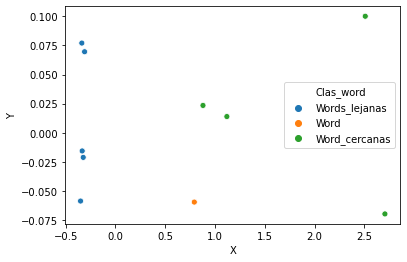

,X,Y,Word,Clas_word
0,-0.350247,-0.058596,serie,Words_lejanas
1,-0.323424,-0.021121,llegada,Words_lejanas
2,-0.333659,-0.015593,ar-,Words_lejanas
3,-0.337580,0.077007,intempestivo,Words_lejanas
4,-0.309681,0.069554,hundían,Words_lejanas
5,0.792156,-0.059486,frente,Word
6,0.879195,0.023465,puso,Word_cercanas
7,1.119086,0.013935,día,Word_cercanas
8,2.705979,-0.069650,fue,Word_cercanas
9,2.508708,0.100028,buendía,Word_cercanas


In [26]:
# your code here
# Seleccionar Modelo
name, model = list(modelos.items())[0]
p1 = 'frente'
graficar_palabras_cercanas_lejanas(p1, model, n=5)

## Relaciónes Interesantes

Utilizando las funciones anteriormente implementadas, tome los tres personajes principales del libro de Cien Años de Soledad:

*   Aureliano
*   Úrsula
*   José

Y gráfique las 5 palabras más cercanas y más lejanas del vocabulario para cada una de estas palabras. En total debe presentar como mínimo tres gráficas *(plots)*, una por cada personaje. Pruebe utilizando los diferentes modelos entrenados y varie los distintos parámetros (size, window, etc.) con los que estos se construyen. Usted es libre de organizar los resultados que desea presentar para argumentar sus conclusiones.

### Aureliano

CBOW 1


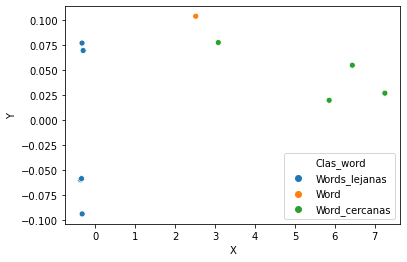

Skip-Gram 1


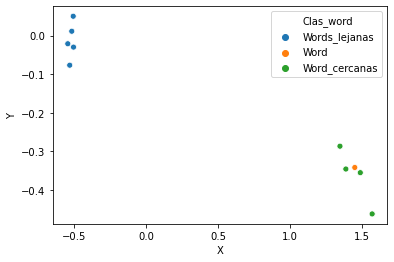

CBOW 2


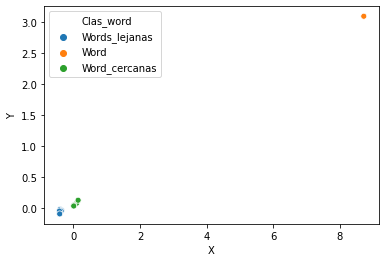

Skip-Gram 2


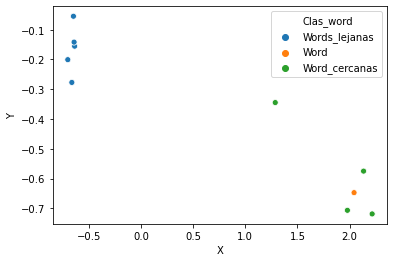

In [27]:
# your code here
df = pd.DataFrame()
for i in range(0,len(list(modelos.items()))):
    name, model = list(modelos.items())[i]
    print(name)
    p1 = 'aureliano'
    df_aux = graficar_palabras_cercanas_lejanas(p1, model, n=5)
    df_aux['Modelo'] = name
    df = pd.concat([df, df_aux])

In [28]:
df

,X,Y,Word,Clas_word,Modelo
0,-0.334662,-0.093948,engendro,Words_lejanas,CBOW 1
1,-0.337580,0.077007,intempestivo,Words_lejanas,CBOW 1
2,-0.374798,-0.059772,fiebres,Words_lejanas,CBOW 1
3,-0.350247,-0.058596,serie,Words_lejanas,CBOW 1
4,-0.309681,0.069554,hundían,Words_lejanas,CBOW 1
5,2.511974,0.103852,aureliano,Word,CBOW 1
6,3.076907,0.077545,»,Word_cercanas,CBOW 1
7,6.436191,0.054841,",",Word_cercanas,CBOW 1
8,7.253285,0.026866,de,Word_cercanas,CBOW 1
9,5.856029,0.019747,la,Word_cercanas,CBOW 1


### Ursula

CBOW 1


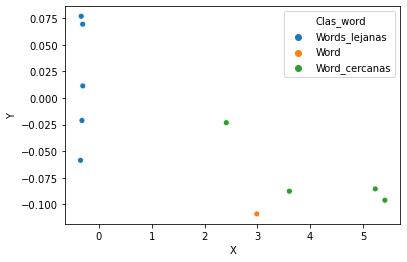

Skip-Gram 1


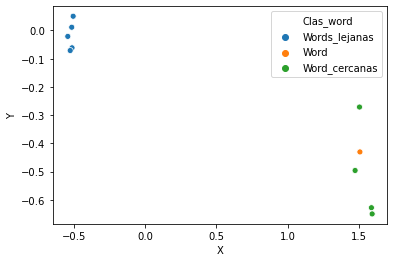

CBOW 2


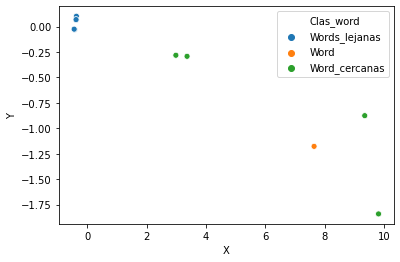

Skip-Gram 2


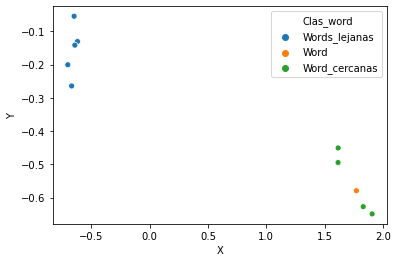

In [29]:
# your code here
df = pd.DataFrame()
for i in range(0,len(list(modelos.items()))):
    name, model = list(modelos.items())[i]
    print(name)
    p1 = 'úrsula'
    df_aux = graficar_palabras_cercanas_lejanas(p1, model, n=5)
    df_aux['Modelo'] = name
    df = pd.concat([df, df_aux])

In [30]:
df

,X,Y,Word,Clas_word,Modelo
0,-0.307985,0.011413,20,Words_lejanas,CBOW 1
1,-0.323424,-0.021121,llegada,Words_lejanas,CBOW 1
2,-0.350247,-0.058596,serie,Words_lejanas,CBOW 1
3,-0.337580,0.077007,intempestivo,Words_lejanas,CBOW 1
4,-0.309681,0.069554,hundían,Words_lejanas,CBOW 1
5,2.987737,-0.109068,úrsula,Word,CBOW 1
6,2.409266,-0.023185,casa,Word_cercanas,CBOW 1
7,3.605079,-0.087677,más,Word_cercanas,CBOW 1
8,5.231381,-0.085512,del,Word_cercanas,CBOW 1
9,5.414195,-0.096148,en,Word_cercanas,CBOW 1


### Jose

CBOW 1


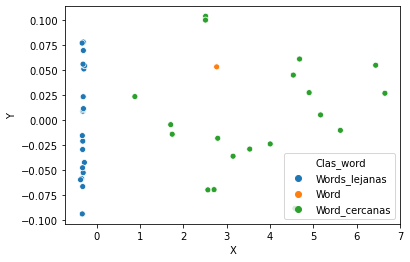

Skip-Gram 1


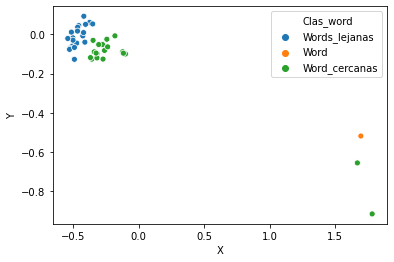

CBOW 2


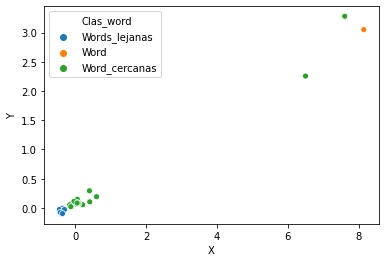

Skip-Gram 2


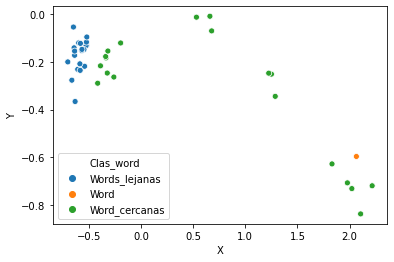

In [31]:
# your code here
# your code here
df = pd.DataFrame()
for i in range(0,len(list(modelos.items()))):
    name, model = list(modelos.items())[i]
    print(name)
    p1 = 'josé'
    df_aux = graficar_palabras_cercanas_lejanas(p1, model, n=20)
    df_aux['Modelo'] = name
    df = pd.concat([df, df_aux])

In [32]:
df

,X,Y,Word,Clas_word,Modelo
0,-0.311266,0.078048,anormal,Words_lejanas,CBOW 1
1,-0.299497,0.051097,conciencia.,Words_lejanas,CBOW 1
2,-0.320595,0.008806,cólera,Words_lejanas,CBOW 1
3,-0.313511,-0.052710,empantanado,Words_lejanas,CBOW 1
4,-0.285615,-0.042458,cum-,Words_lejanas,CBOW 1
...,...,...,...,...,...
35,-0.387775,-0.217079,-llévenme,Word_cercanas,Skip-Gram 2
36,2.021452,-0.730489,dio,Word_cercanas,Skip-Gram 2
37,-0.322609,-0.247189,acostumbrarse,Word_cercanas,Skip-Gram 2
38,1.224683,-0.247682,reveló,Word_cercanas,Skip-Gram 2


## Conclusiones

¿Qué relaciones interesantes encuentra? ¿Tienen sentido la cercanía y la lejanía de dichas palabras? ¿A qué se puede deber este comportamiento dados los parametros y modelos que usted seleccionó?

Escriba sus conclusiones a continuación:

Los modelos de extracción de texto como CBOW (Continuous Bag of Words) y Skip-gram, se utilizan en procesamiento de lenguaje natural para aprender representaciones vectoriales de palabras o caracteres. En el Taller se evidencia que los Modelos Skip-Gram son los que mejor clasifican las palabras cercanas y lejanas a la palabra de interés, la nube de puntos de estos modelos es más densa y diferenciada entres las palabras cercanas y lejanas entre si.

Los Modelos CBOW ignora el orden de las palabras en una oración, ya que considera un contexto dado como una "bolsa de palabras". Esto puede ser problemático en tareas donde el orden de las palabras es crítico como por ejemplo en este caso con el fragmento del libro de “100_años_soledad” por lo que puede generar la agrupación errónea al no tener en cuenta el orden y cohesión de texto.

Para tratar de resolver el problema se podría utilizar un vocabulario más grande que pueda ayudar a reducir la similitud entre los vectores de las palabras y utilizar un conjunto de datos de entrenamiento más representativo o un conjunto de datos de texto específico como fragmentos de libros de Gabriel Garcia Marquez con el fin de mejorar la precisión de los vectores de las palabras.

# Referencias
https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314